In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%reload_ext autoreload

In [3]:
import os

# move to project root
while True:
    # get list of directories
    dirs = os.listdir()
    if "README.md" in dirs:
        break
    else:
        os.chdir("..")
print(os.getcwd())

/mnt/antares_raid/home/bramantyos/codes/multilang_timescale


In [24]:
import numpy as np
import pandas as pd

import cortex

import matplotlib.pyplot as plt
import seaborn as sns

from src.utils import (
    read_result_meta,
    get_surface_dict,
    put_values_on_mask,
    two_side_ks_test,
    timescale_permutation_test
)

from src.plot_utils import plot_flatmap_from_vertex
from src.configurations import timescale_ranges

from voxelwise_tutorials.io import load_hdf5_sparse_array

In [5]:
from src.configurations import config_plotting

config_plotting("paper")

In [6]:
surfaces_json = ".temp/fmri/bling/surfaces.json"
surfaces_dir = "/mnt/raid/bling/share/pycortex_store"

mapper_dir = "/mnt/raid/bling/share/mappers"

result_metric = "r2"
result_meta_dir = ".temp/result_meta/bling"

subjects_ids = ["COL", "GFW", "TYE"]
languages = ["en", "zh"]

fsaverage_surface = "fsaverage"

yeos_label_dir = ".temp/misc/Yeo_JNeurophysiol11_FreeSurfer/fsaverage/label"

alpha = 0.05
alpha_pred_acc = None

In [7]:
timescale_data = {}
prediction_acc_data = {}

for subject_id in subjects_ids:
    surface_dict = get_surface_dict(subject_id)

    subject_file_en = f".temp/config/bling/subject/{subject_id}_en.json"
    subject_file_zh = f".temp/config/bling/subject/{subject_id}_zh.json"

    trainer_en_file = (
        f".temp/config/bling/train/stepwise/{subject_id.lower()}_en_timescale.json"
    )
    trainer_zh_file = (
        f".temp/config/bling/train/stepwise/{subject_id.lower()}_zh_timescale.json"
    )

    feature_file_en = f".temp/config/bling/feature/{subject_id}/mBERT_all_untrimmed_timescale_stepwise_en.json"
    feature_file_zh = f".temp/config/bling/feature/{subject_id}/mBERT_all_untrimmed_timescale_stepwise_zh.json"

    mapper_file = os.path.join(mapper_dir, f"{subject_id}_fsaverage_mapper.hdf")

    en_meta_df = read_result_meta(
        result_meta_dir,
        trainer_setting_path=trainer_en_file,
        subject_setting_path=subject_file_en,
        feature_setting_path=feature_file_en,
    )
    zh_meta_df = read_result_meta(
        result_meta_dir,
        trainer_setting_path=trainer_zh_file,
        subject_setting_path=subject_file_zh,
        feature_setting_path=feature_file_zh,
    )

    en_config = en_meta_df.iloc[0].to_dict()
    zh_config = zh_meta_df.iloc[0].to_dict()

    en_stats = np.load(en_config["stats_path"])
    zh_stats = np.load(zh_config["stats_path"])

    keyword = f"test_{result_metric}_selectivity_mask"
    pred_acc_keyword = f"test_joint_{result_metric}_score_mask"
    p_val_keyword = f"test_p_values_{result_metric}_mask"

    timescale_en, _ = put_values_on_mask(
        en_stats[keyword],
        en_stats[p_val_keyword],
        ev_mask=None,
        alpha=alpha,
        valid_range=(8, 256),
    )

    timescale_zh, _ = put_values_on_mask(
        zh_stats[keyword],
        zh_stats[p_val_keyword],
        ev_mask=None,
        alpha=alpha,
        valid_range=(8, 256),
    )

    if result_metric == "r2":
        en_pred = np.sqrt(en_stats[pred_acc_keyword])
        zh_pred = np.sqrt(zh_stats[pred_acc_keyword])

    pred_acc_en, _ = put_values_on_mask(
        en_stats[pred_acc_keyword],
        en_stats[p_val_keyword],
        ev_mask=None,
        alpha=alpha,
        valid_range=(0, 1),
    )

    pred_acc_zh, _ = put_values_on_mask(
        zh_stats[pred_acc_keyword],
        zh_stats[p_val_keyword],
        ev_mask=None,
        alpha=alpha,
        valid_range=(0, 1),
    )

    # project to fsaverage
    mapper = load_hdf5_sparse_array(mapper_file, key="voxel_to_fsaverage")

    projected_en = timescale_en @ mapper.T
    projected_zh = timescale_zh @ mapper.T

    projected_pred_acc_en = pred_acc_en @ mapper.T
    projected_pred_acc_zh = pred_acc_zh @ mapper.T

    # drop nan
    timescale_data[subject_id] = {
        "en": projected_en,
        "zh": projected_zh,
    }

    prediction_acc_data[subject_id] = {
        "en": projected_pred_acc_en,
        "zh": projected_pred_acc_zh,
    }

/tmp/ipykernel_2778045/800668282.py:62: RuntimeWarning: invalid value encountered in sqrt
  en_pred = np.sqrt(en_stats[pred_acc_keyword])
/tmp/ipykernel_2778045/800668282.py:63: RuntimeWarning: invalid value encountered in sqrt
  zh_pred = np.sqrt(zh_stats[pred_acc_keyword])
/tmp/ipykernel_2778045/800668282.py:62: RuntimeWarning: invalid value encountered in sqrt
  en_pred = np.sqrt(en_stats[pred_acc_keyword])
/tmp/ipykernel_2778045/800668282.py:63: RuntimeWarning: invalid value encountered in sqrt
  zh_pred = np.sqrt(zh_stats[pred_acc_keyword])
/tmp/ipykernel_2778045/800668282.py:62: RuntimeWarning: invalid value encountered in sqrt
  en_pred = np.sqrt(en_stats[pred_acc_keyword])
/tmp/ipykernel_2778045/800668282.py:63: RuntimeWarning: invalid value encountered in sqrt
  zh_pred = np.sqrt(zh_stats[pred_acc_keyword])


# YEO's Parcelation

In [8]:
import nibabel as nib

In [9]:
cluster_to_labels_dict_large = {
    "frontal": [
        "caudalmiddlefrontal",
        "rostralmiddlefrontal",
        "superiorfrontal",
        "lateralorbitofrontal",
        #"medialorbitofrontal",
        #"parsopercularis",
        #"parsorbitalis",
        "parstriangularis",
    ],
    "temporalparietal": [
        #"parsopercularis",
        #"parsorbitalis",
        "parstriangularis",
        "precuneus",
        #"superiorparietal",
        "inferiorparietal",
        "supramarginal",
        "inferiortemporal",
        "middletemporal",
        "superiortemporal",
        "bankssts",
        #"parahippocampal",
    ],
}
all_labels = (
    cluster_to_labels_dict_large["frontal"]
    + cluster_to_labels_dict_large["temporalparietal"]
)

In [10]:
all_labels_df = pd.DataFrame(all_labels)
# add cluster to df
all_labels_df["cluster"] = all_labels_df[0].apply(
    lambda x: (
        "frontal"
        if x in cluster_to_labels_dict_large["frontal"]
        else "temporalparietal"
    )
)

all_labels_df.columns = ["label", "cluster"]

all_labels_df.head()

,label,cluster
0,caudalmiddlefrontal,frontal
1,rostralmiddlefrontal,frontal
2,superiorfrontal,frontal
3,lateralorbitofrontal,frontal
4,parstriangularis,frontal


In [11]:
# lh_annot = nib.freesurfer.io.read_annot(
#     os.path.join(yeos_label_dir, f"lh.Yeo2011_17Networks_N1000.annot")
# )
# rh_annot = nib.freesurfer.io.read_annot(
#     os.path.join(yeos_label_dir, f"rh.Yeo2011_17Networks_N1000.annot")
# )

lh_annot = nib.freesurfer.io.read_annot(os.path.join(yeos_label_dir, f"lh.aparc.annot"))
rh_annot = nib.freesurfer.io.read_annot(os.path.join(yeos_label_dir, f"rh.aparc.annot"))


num_fsaverage_vertices = 327684
num_networks = 17

lh_mask = np.arange(int(num_fsaverage_vertices // 2))
rh_mask = np.arange(int(num_fsaverage_vertices // 2), num_fsaverage_vertices)

In [12]:
lh_cluster, lh_areas, lh_annots = lh_annot
rh_cluster, rh_areas, rh_annots = rh_annot

# annots to str
lh_annots = [str(x, "utf-8") for x in lh_annots]
rh_annots = [str(x, "utf-8") for x in rh_annots]

In [13]:
# maps lh_annots to int, create a dict
lh_annots_dict = {lh_annots[i]: i for i in range(len(lh_annots))}
rh_annots_dict = {rh_annots[i]: i for i in range(len(rh_annots))}

# add annot to df
all_labels_df["lh_annot"] = all_labels_df["label"].apply(
    lambda x: lh_annots_dict[x] if x in lh_annots_dict else None
)

all_labels_df["rh_annot"] = all_labels_df["label"].apply(
    lambda x: rh_annots_dict[x] if x in rh_annots_dict else None
)

In [14]:
all_labels_df

,label,cluster,lh_annot,rh_annot
0,caudalmiddlefrontal,frontal,3,3
1,rostralmiddlefrontal,frontal,27,27
2,superiorfrontal,frontal,28,28
3,lateralorbitofrontal,frontal,12,12
4,parstriangularis,frontal,20,20
5,parstriangularis,frontal,20,20
6,precuneus,temporalparietal,25,25
7,inferiorparietal,temporalparietal,8,8
8,supramarginal,temporalparietal,31,31
9,inferiortemporal,temporalparietal,9,9


In [15]:
included_vertices = []

for label_df_idx in range(len(all_labels_df)):
    label = all_labels_df.iloc[label_df_idx]
    label_name = label["label"]
    lh_annot = label["lh_annot"]
    rh_annot = label["rh_annot"]

    v = np.array(
        list(
            set(
                list(lh_mask[np.where(lh_cluster == lh_annot)[0]])
                + list(rh_mask[np.where(rh_cluster == rh_annot)[0]])
            )
        )
    )

    included_vertices.append(v)

In [16]:
# iterate over subject, lang, and all labels
from itertools import product

parcel_timescale = []

for subject_id, lang, label_df_idx in product(
    subjects_ids, languages, range(len(all_labels_df))
):
    label = all_labels_df.iloc[label_df_idx]
    label_name = label["label"]
    v = included_vertices[label_df_idx]

    data = timescale_data[subject_id][lang]
    data = data[v]

    parcel_timescale.append(
        {
            "subject_id": subject_id,
            "language": lang,
            "area_name": label_name,
            "data": data,
        }
    )

In [17]:
parcel_timescale_df = pd.DataFrame(parcel_timescale)
parcel_timescale_df.head()

,subject_id,language,area_name,data
0,COL,en,caudalmiddlefrontal,"[nan, nan, nan, nan, nan, nan, nan, 151.861312..."
1,COL,en,rostralmiddlefrontal,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
2,COL,en,superiorfrontal,"[nan, nan, nan, nan, nan, nan, nan, 45.7281265..."
3,COL,en,lateralorbitofrontal,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
4,COL,en,parstriangularis,"[nan, nan, 226.83396909352754, nan, nan, nan, ..."


In [18]:
tempoparietal_df = all_labels_df[all_labels_df["cluster"] == "temporalparietal"]
frontal_df = all_labels_df[all_labels_df["cluster"] == "frontal"]

In [31]:
frontal_df

,label,cluster,lh_annot,rh_annot
0,caudalmiddlefrontal,frontal,3,3
1,rostralmiddlefrontal,frontal,27,27
2,superiorfrontal,frontal,28,28
3,lateralorbitofrontal,frontal,12,12
4,parstriangularis,frontal,20,20
5,parstriangularis,frontal,20,20


In [32]:
def plot_histogram_per_parcel(parcel_df: pd.DataFrame, parcel_timescale_df: pd.DataFrame):
    parcels = parcel_df['label'].unique().tolist()
    n_parcel=len(parcels)
    n_sub = parcel_timescale_df['subject_id'].nunique()
    subject_ids = parcel_timescale_df['subject_id'].unique().tolist()
    # now for each subject and language create a histogram
    fig, axs = plt.subplots(n_sub, n_parcel, 
                            figsize=(24, 12),sharex=True, sharey='row')

    timescale_diff = []
    for i, subject_id in enumerate(subject_ids):
        for j, area_name in enumerate(parcels):
            
            # EN Histogram
            data_en = parcel_timescale_df[
                (parcel_timescale_df["subject_id"] == subject_id)
                & (parcel_timescale_df["language"] == "en")
                & (parcel_timescale_df["area_name"] == area_name)
            ]["data"].values[0]

            # ZH Histogram
            data_zh = parcel_timescale_df[
                (parcel_timescale_df["subject_id"] == subject_id)
                & (parcel_timescale_df["language"] == "zh")
                & (parcel_timescale_df["area_name"] == area_name)
            ]["data"].values[0]

            valid_en_voxel = np.where(~np.isnan(data_en))[0]
            valid_zh_voxel = np.where(~np.isnan(data_zh))[0]

            shared_voxel = np.intersect1d(valid_en_voxel, valid_zh_voxel)

            data_en = data_en[shared_voxel]
            data_zh = data_zh[shared_voxel]

            assert len(data_en) == len(data_zh)

            if (len(data_en)>1 and len(data_zh)>1):
                pval, _ = timescale_permutation_test(data_en, data_zh)
            else:
                pval=1

            # diff
            diff = data_en - data_zh

            timescale_diff.append(
                {
                    "subject_id": subject_id,
                    "area": area_name,
                    "diff": diff,
                    "pval": pval,
                }
            )

            # check if len > 1
            if len(data_en) > 1 :
                sns.kdeplot(
                    data_en, color="blue", label="EN", fill=True, ax=axs[i, j], clip=(0, 256)
                )
                
            if len(data_zh)>1:
                sns.kdeplot(
                    data_zh, color="red", label="ZH", fill=True, ax=axs[i, j], clip=(0, 256)
                )

            # sns.histplot(data_en, color="blue", label="EN", ax=axs[i, j], kde=True, bins=16, stat="density", alpha=0.2, clip=(0, 256))
            # sns.histplot(data_zh, color="red", label="ZH", ax=axs[i, j], kde=True, bins=16, stat="density", alpha=0.2, clip=(0, 256))
            # sns.kdeplot(diff, color="green", label="Diff", fill=True, ax=axs[i, j])

            axs[i, j].set_title(f"{subject_id} - {area_name} (p-val={pval:.3f})")
            axs[i, j].set_xlim(0, 256)

    plt.tight_layout()
    plt.show()

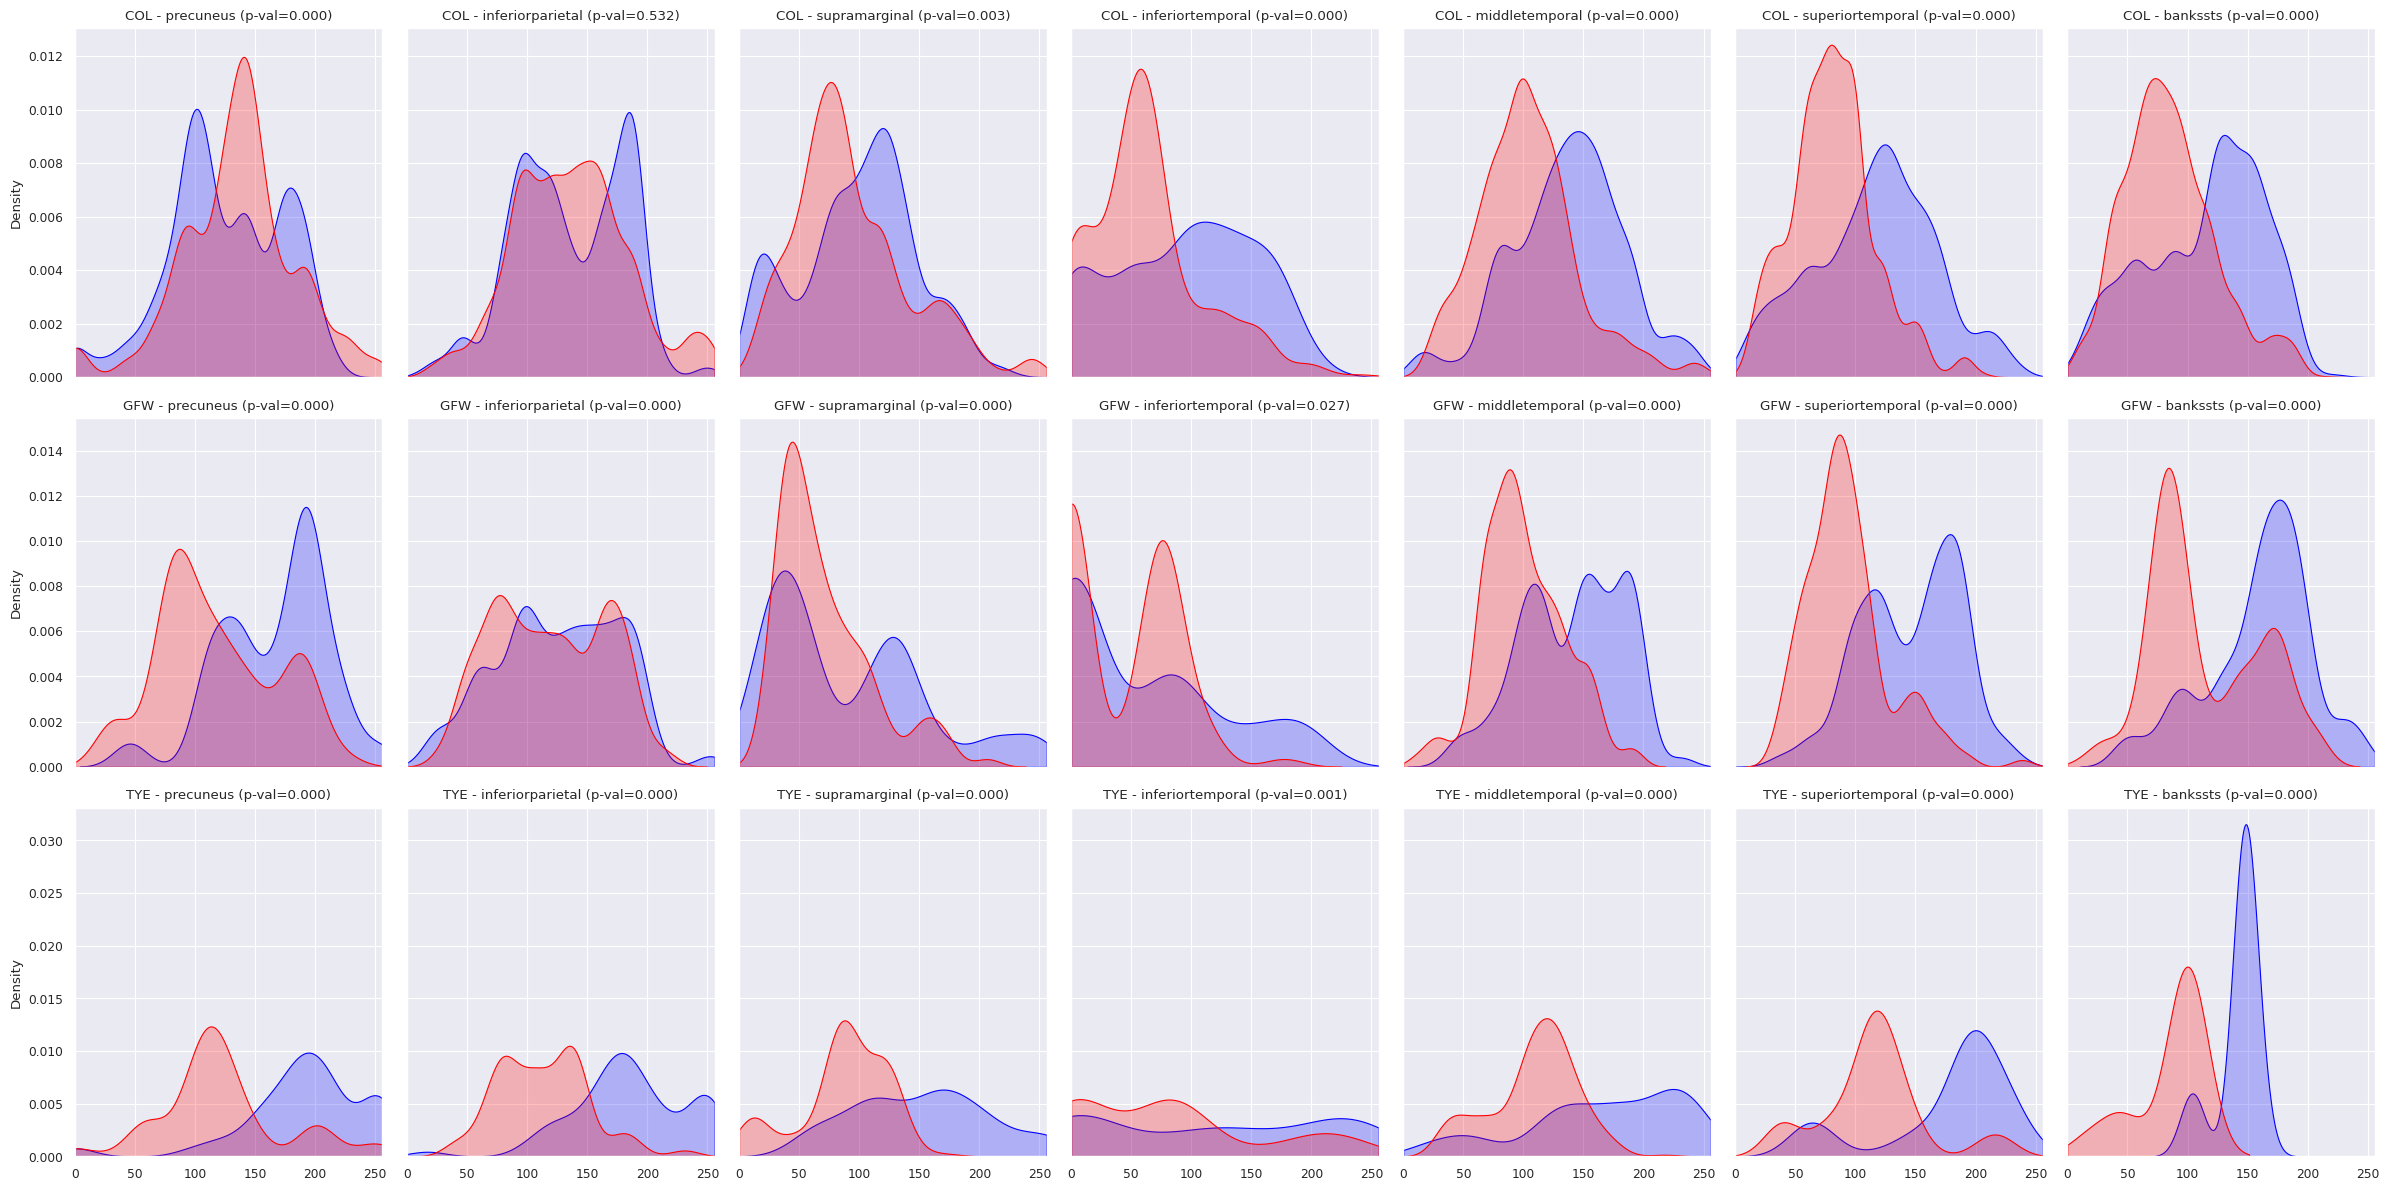

In [33]:
plot_histogram_per_parcel(tempoparietal_df,parcel_timescale_df )

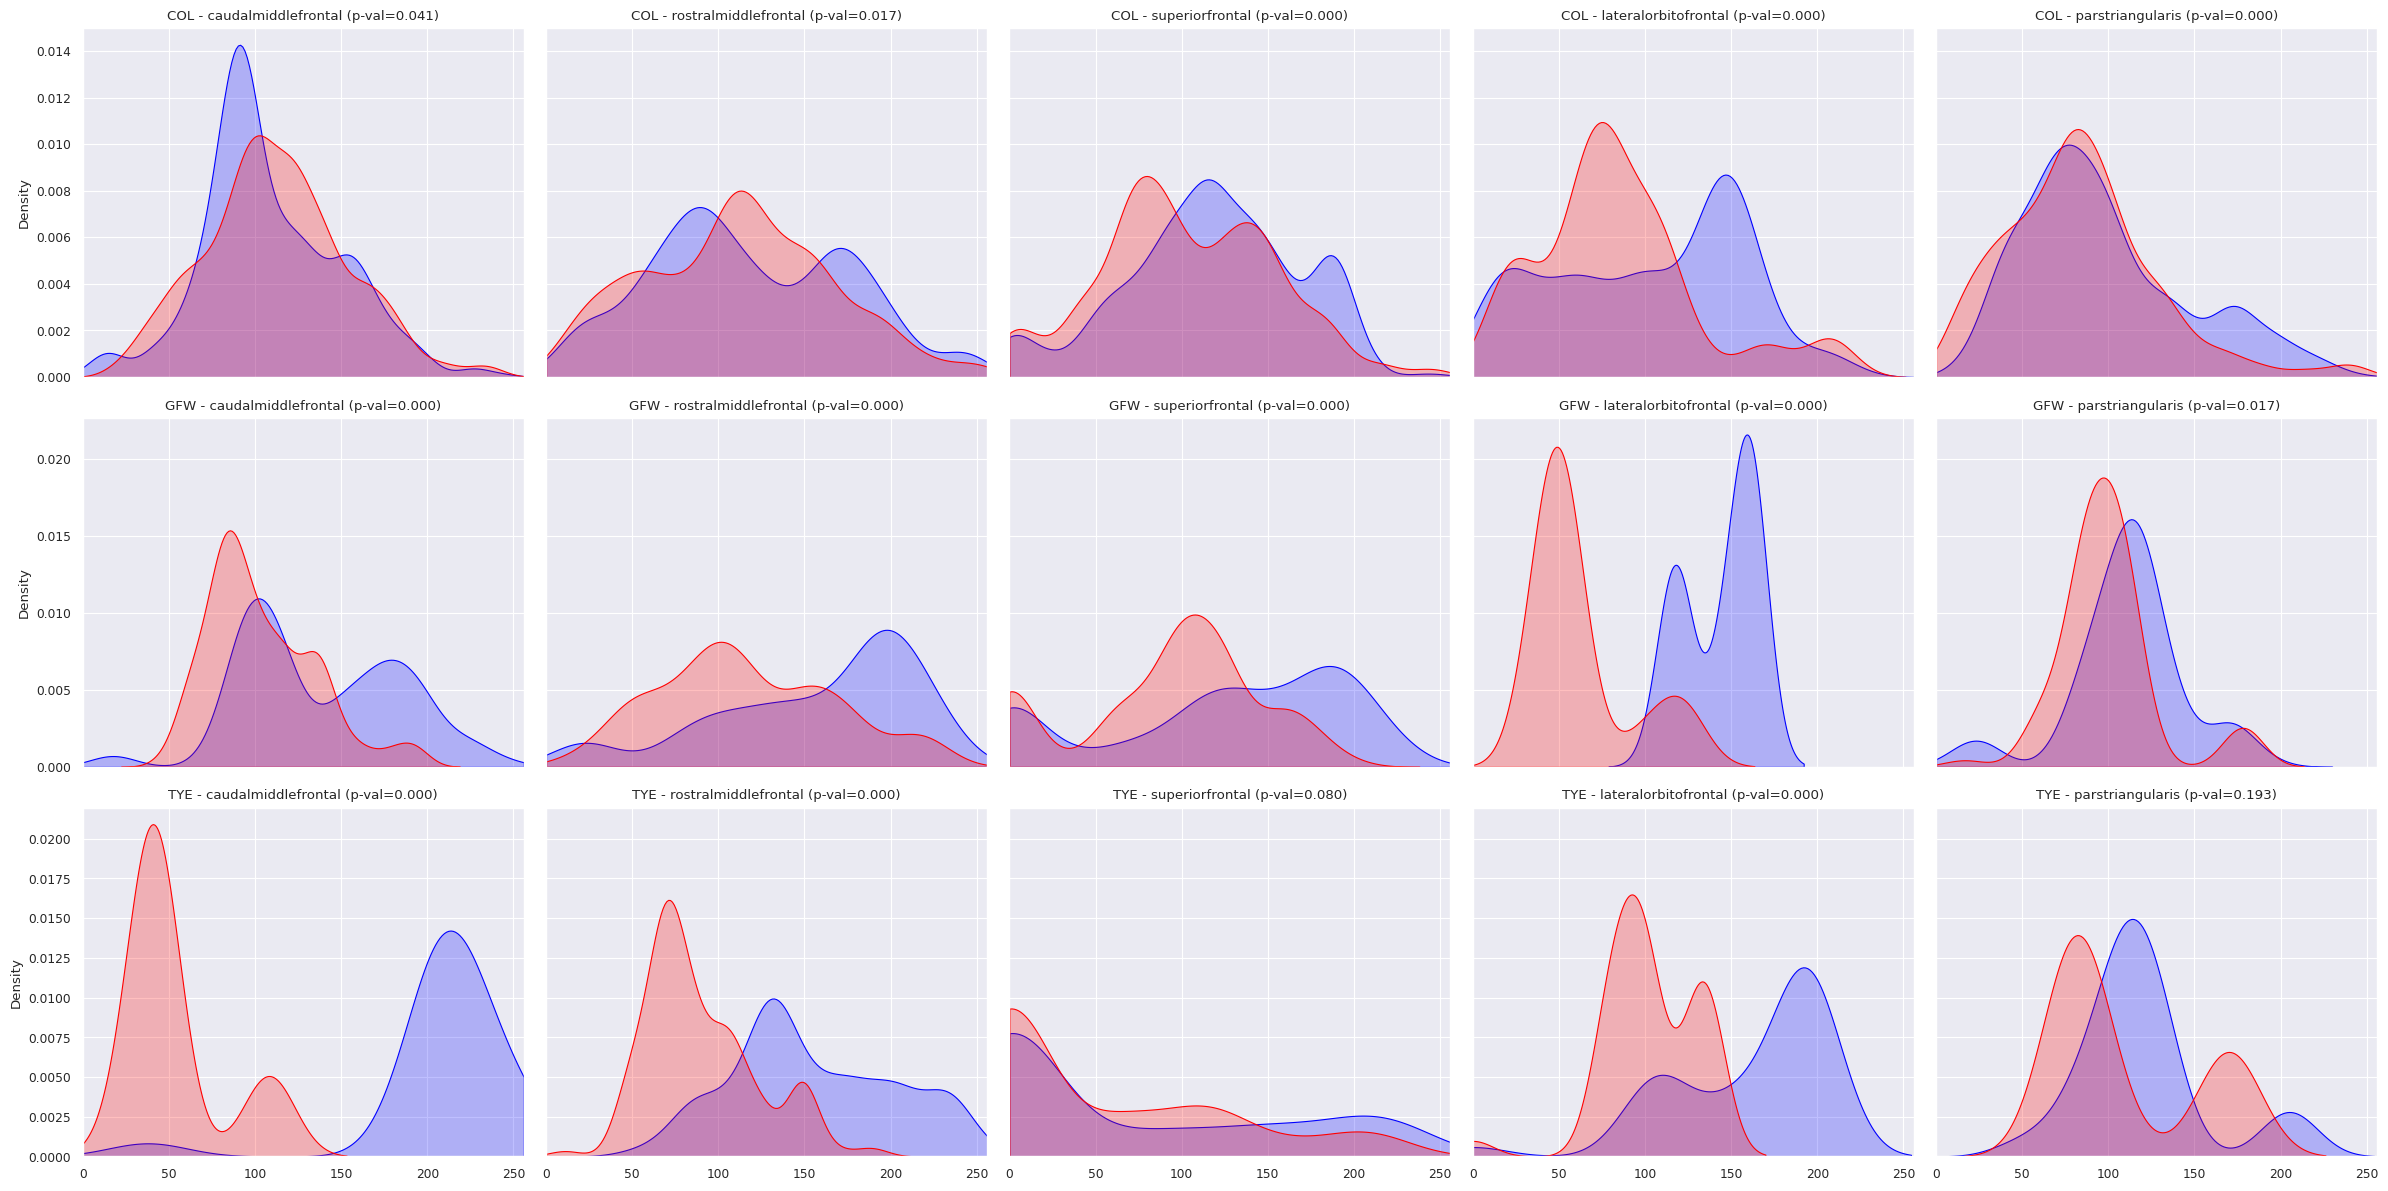

In [34]:
plot_histogram_per_parcel(frontal_df,parcel_timescale_df )

In [35]:
# timescale_diff_df = pd.DataFrame(timescale_diff)

# fig, axs = plt.subplots(3, 8, figsize=(20, 10), sharex=True, sharey=True)

# for i, subject_id in enumerate(subjects_ids):
#     for j, area_name in enumerate(areas_to_parcels_dict.keys()):
#         cur_data = timescale_diff_df[
#             (timescale_diff_df["subject_id"] == subject_id)
#             & (timescale_diff_df["area"] == area_name)
#         ]

#         diff = cur_data["diff"].values[0]
#         pval = cur_data["pval"].values[0]

#         sns.kdeplot(
#             diff, color="green", label="Diff", fill=True, ax=axs[i, j], cumulative=True
#         )

#         axs[i, j].set_title(f"{subject_id} - {area_name} (p-val={pval:.3f})")
#         axs[i, j].set_xlim(-128, 128)

# plt.tight_layout()
# plt.show()

# Plotting the Desikan Kiliany Annotation

In [37]:
# # get vertices and join them non-repeating
# tp_vertices = tempoparietal_df["vertices"].values
# tp_vertices = np.concatenate(tp_vertices)
# tp_vertices = np.unique(tp_vertices)

# frontal_vertices = frontal_df["vertices"].values
# frontal_vertices = np.concatenate(frontal_vertices)
# frontal_vertices = np.unique(frontal_vertices)

In [38]:
# all_vertives = np.zeros(num_fsaverage_vertices)

# tp_all_vertices = np.zeros(num_fsaverage_vertices)
# tp_all_vertices[tp_vertices] = 1

# frontal_all_vertices = np.zeros(num_fsaverage_vertices)
# frontal_all_vertices[frontal_vertices] = 1

# tp_all_vertices = cortex.Vertex(
#     tp_all_vertices, fsaverage_surface, vmin=0, vmax=1, cmap="viridis"
# )
# frontal_all_vertices = cortex.Vertex(
#     frontal_all_vertices, fsaverage_surface, vmin=0, vmax=1, cmap="viridis"
# )

Background RRGGBBAA: ffffff00
Area 0:0:2274.66:1024 exported to 2275 x 1024 pixels (96 dpi)


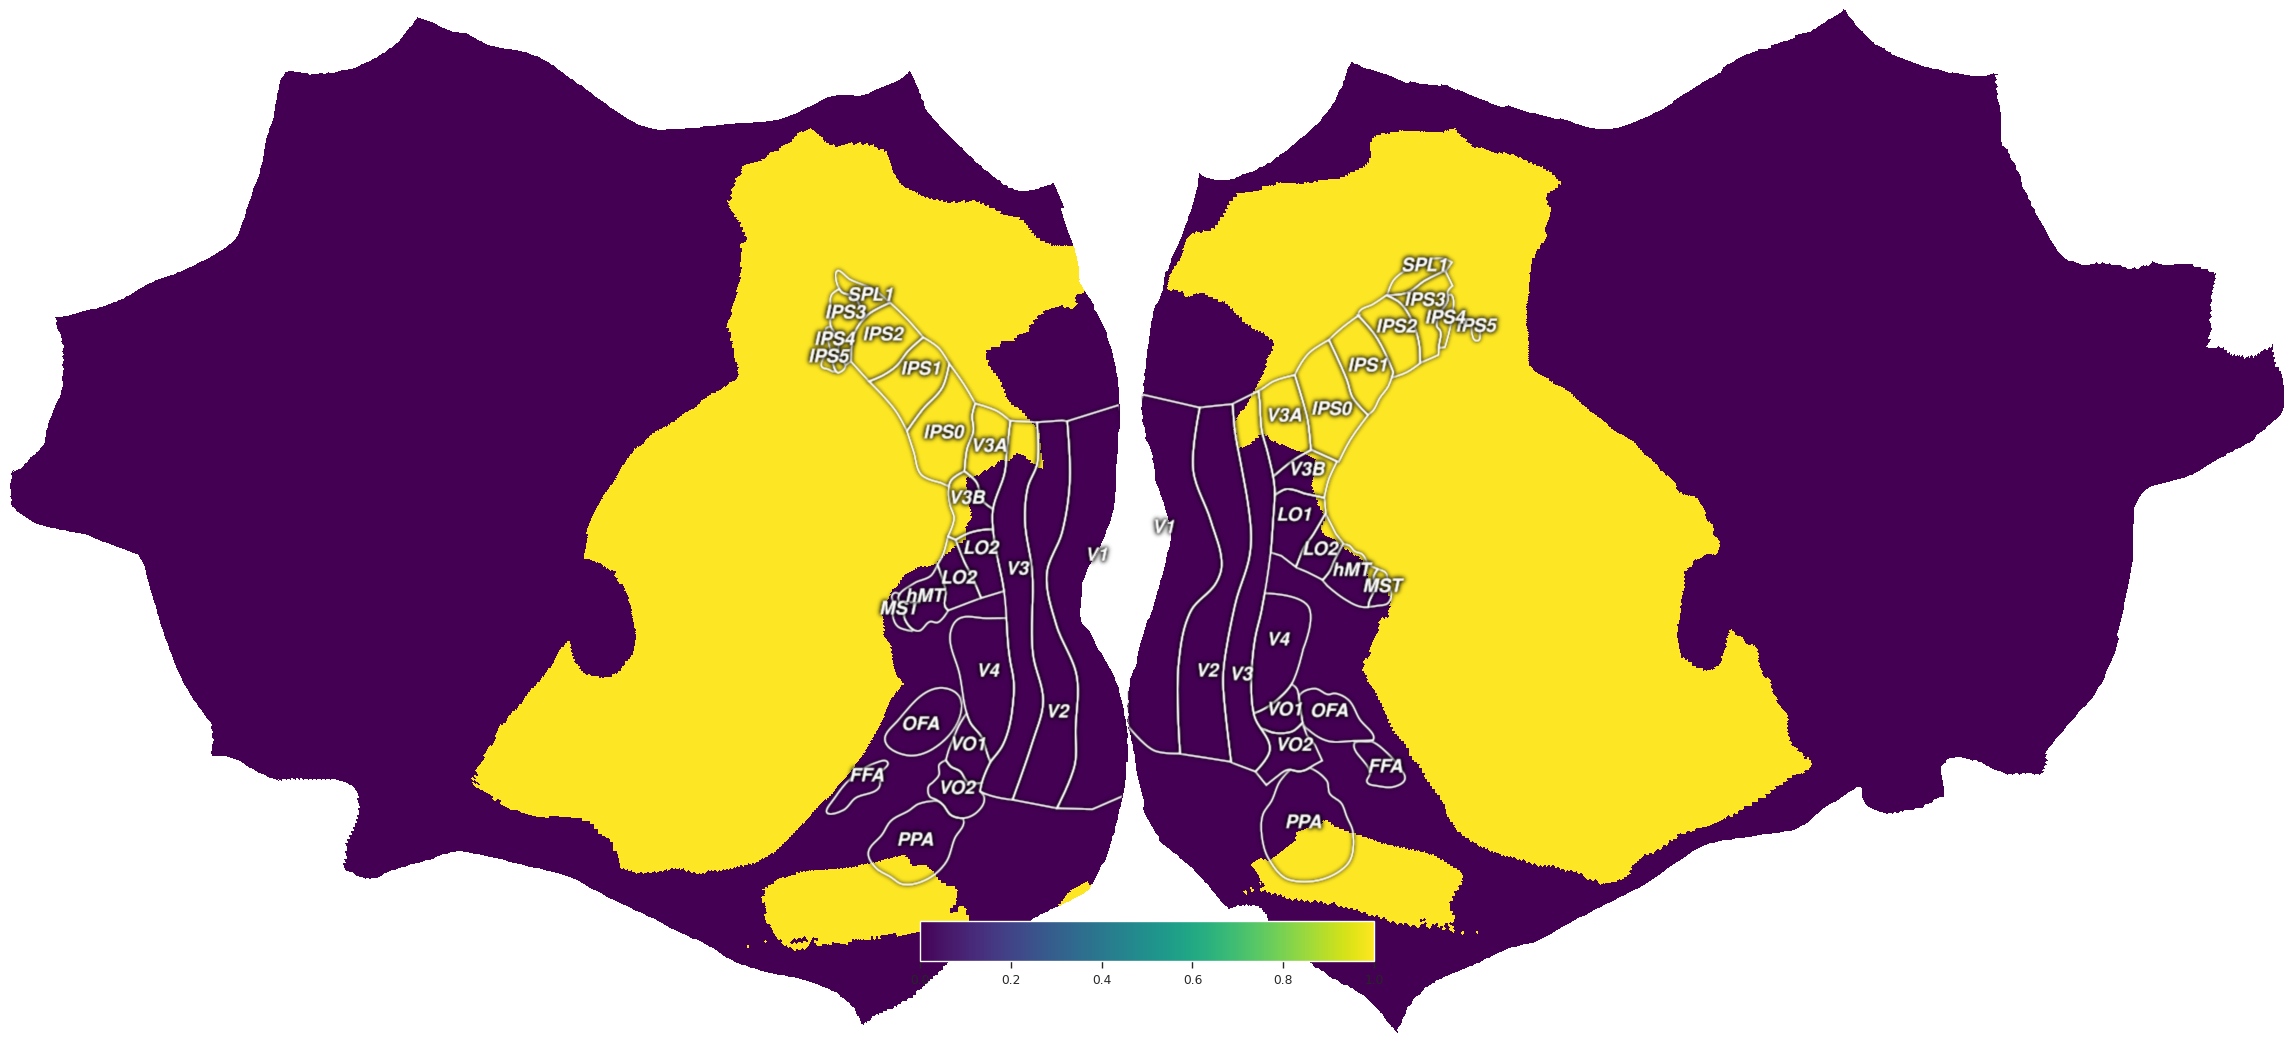

In [ ]:
# cortex.quickflat.make_figure(tp_all_vertices, nanmean=True)

# plt.show()

Background RRGGBBAA: ffffff00
Area 0:0:2274.66:1024 exported to 2275 x 1024 pixels (96 dpi)


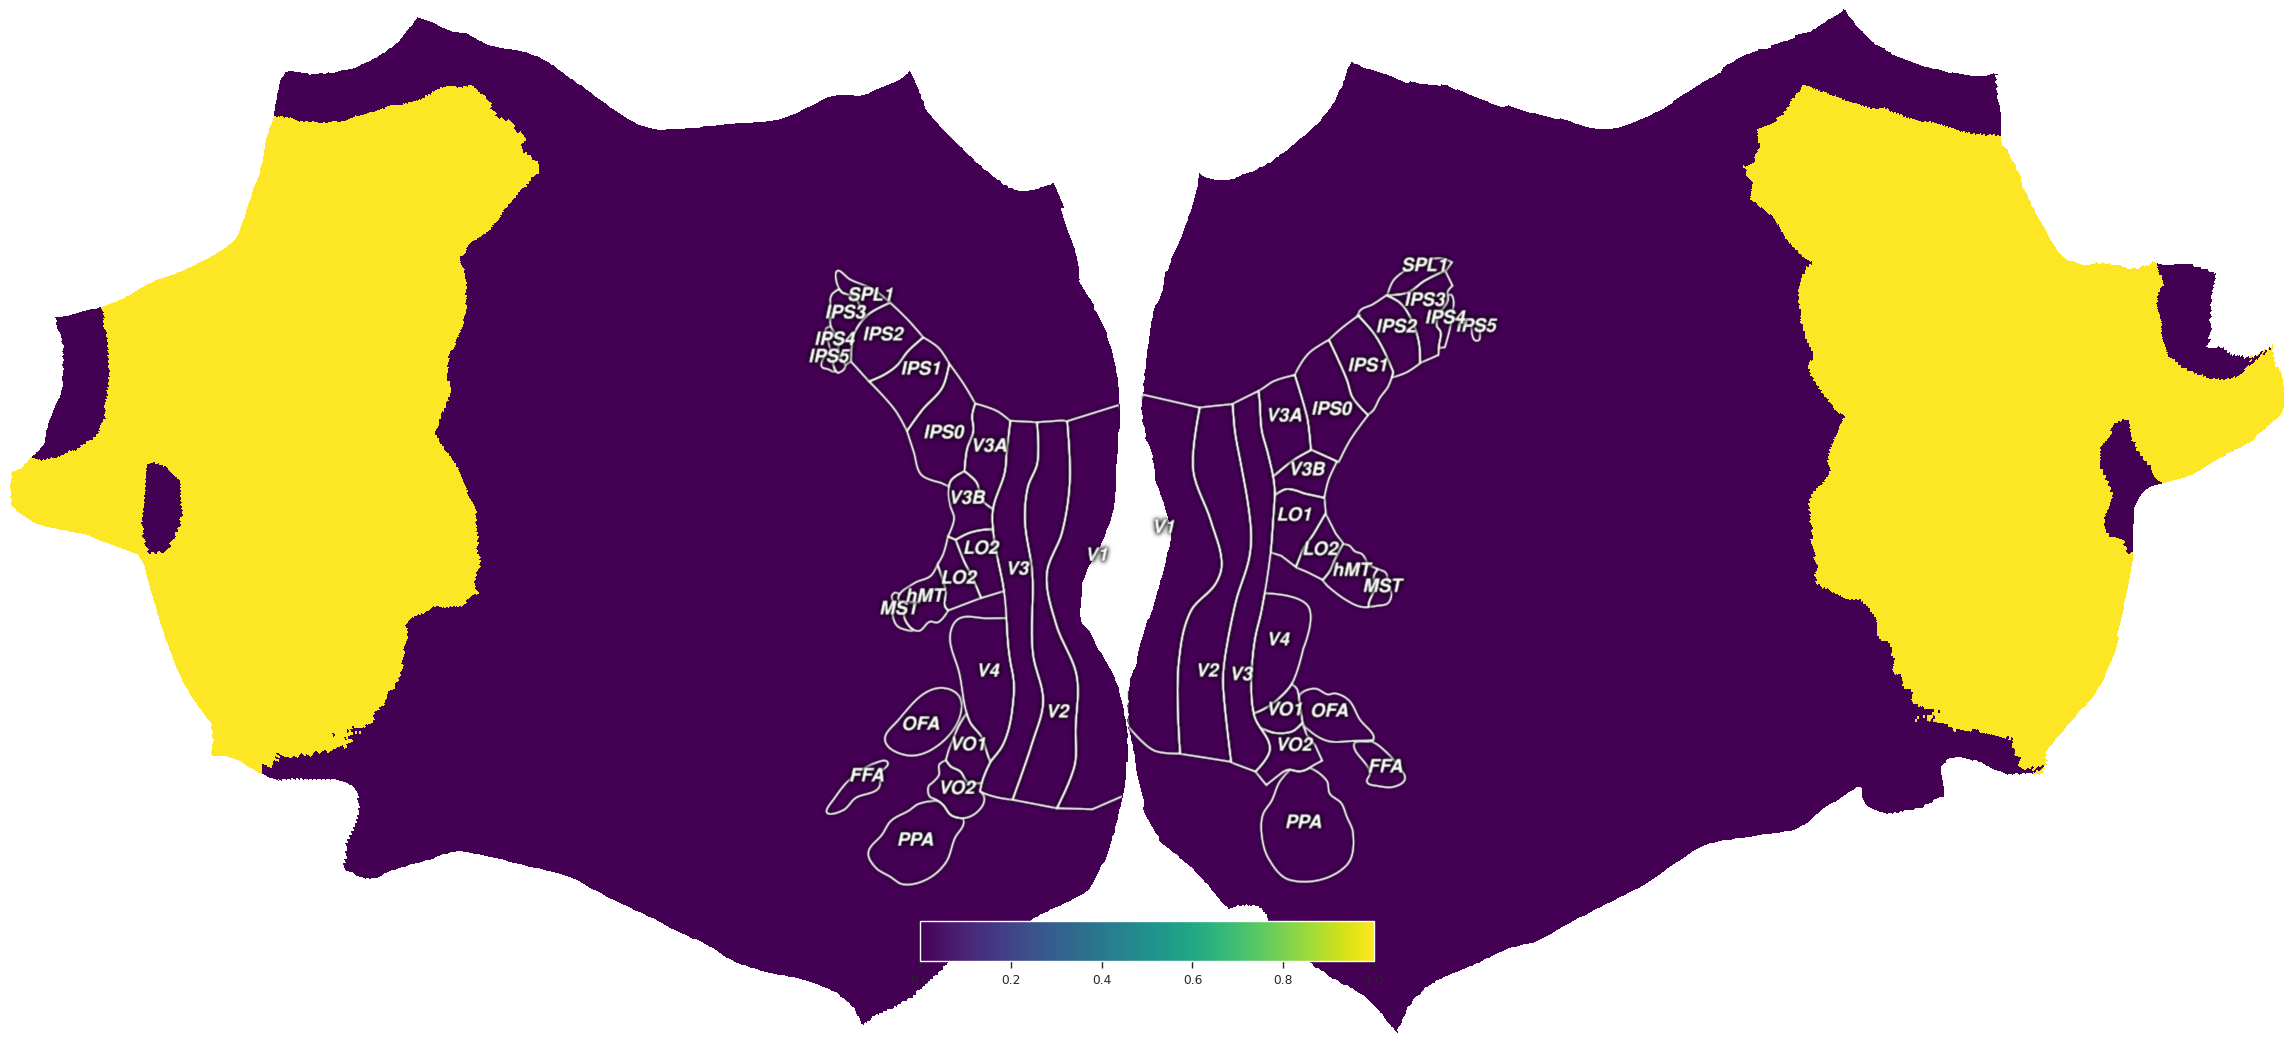

In [ ]:
# cortex.quickflat.make_figure(frontal_all_vertices, nanmean=True)

# plt.show()